# Artificial Intelligence (CS6364-002) 
## Homework 7
## Submission by - Adithya Sundararajan Iyer (asi200000)


In this homework, we aim to solve the “cliff walking” problem using reinforcement learning (RL) techniques. We call “agent” who is to learn to behave intelligently, and here, agent’s aim is to reach the goal. The size of the grid is 6 × 10 (see below). Agent starts at the leftmost cell in the bottom, that is, (6, 1). The goal is the rightmost cell in the bottom (blue), that is, (6, 10). All the cells between (6, 2) and (6, 9) is the cliff (red). If the agent enters the cliff, which means the agent falls into the cliff, then the agent will die. So the aim of the agent is to reach the goal (dark green) alive.

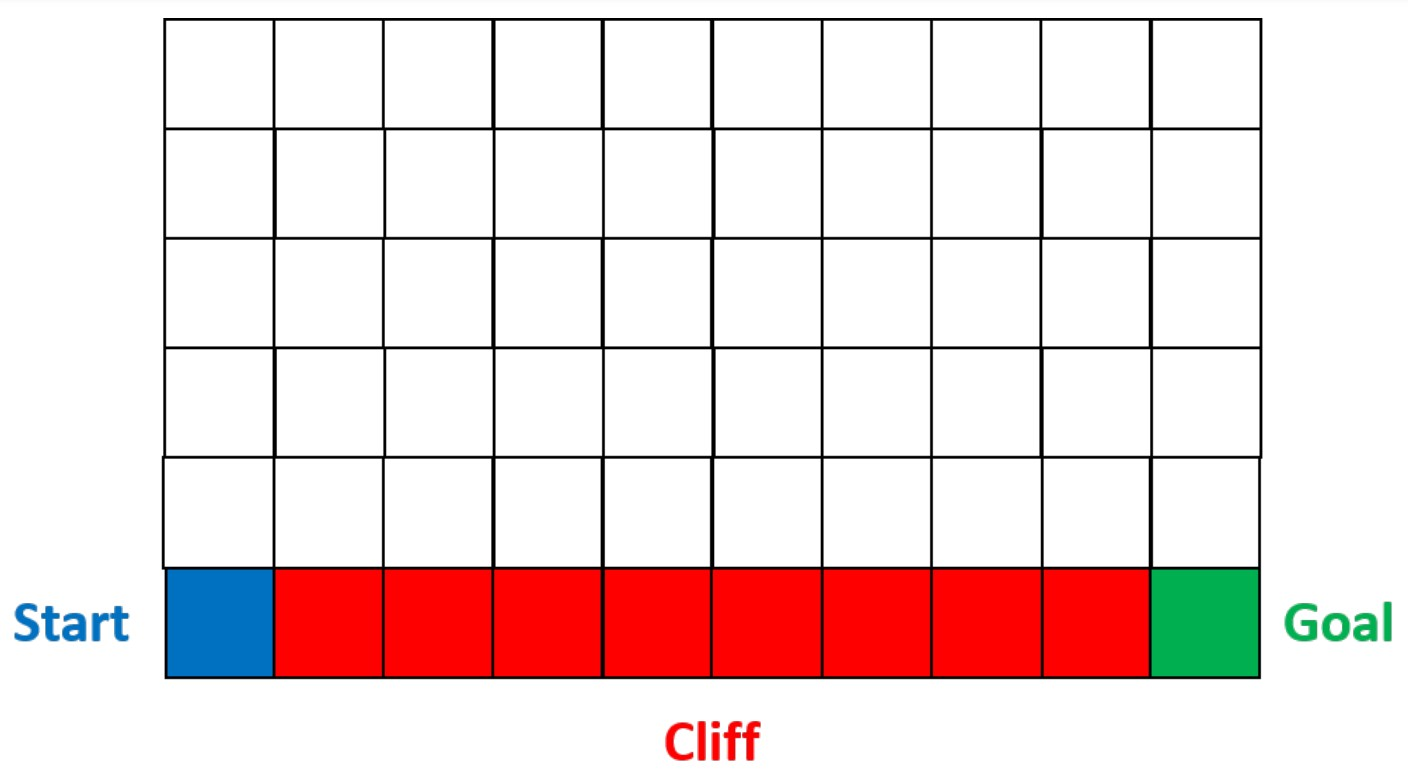

Agent can move only one cell at a time to the neighboring cell, that is, up, down, right and left, unless the agent touches the border. When the agent touches the border, the action that makes the agent cross the border is
not performed but it must remain stopped at the point waiting until the next action. For example, if the agent is at (1, 3) and the action is to up, then agent remains at that point, and if the next action is to right, then it moves
to (1, 4), or when the next action is down then agent moves to (2, 3).

In [1]:
import torch
import torch.nn as nn
import numpy as np
from itertools import count

In RL, an agent takes one state at a time chosen from predefined all possible states. In each of those states, all possible actions are given each with a probability of how likely the action will be chosen. Agent in RL behaves
following its policy. Thus, RL is defined with a set of states S and a set of actions A. Then, we have a table called policy in which each pair of all possible states and actions is given its probability to be occured. Starting
with a random assignment of this probability at the beginning, the policy will be renewed according to the agent’s experience.

In [2]:
GAMMA = 0.7
REWARD = -5
NEG = -100
R,L,U,D = 0,1,2,3

We set a negative reward r = −5 for each transition and a discount factor γ = 0.7. Our goal is to reach the “Goal” in least number of actions.

In [3]:
class Game:

  def __init__(self, dimX, dimY, start, goal, cliffCd, rwrd, lose):
    
    self.dimX, self.dimY = dimX, dimY
    self.grid = np.zeros((dimY, dimX), dtype=int)
    self.currX, self.currY = start
    self.startX, self.startY = self.currX - 1, self.currY - 1
    self.goalX, self.goalY = goal
    self.grid[self.goalY-1][self.goalX-1] = 1
    for y,x in cliffCd:
      self.grid[y-1][x-1] = 2
    self.rwrd = rwrd
    self.lose = lose
    self.sz = dimX*dimY

    self.actions = {
        R: lambda y,x: (y,x+1) if x<(dimX-1) else (y,x),
        L: lambda y,x: (y,x-1) if x>0 else (y,x),
        U: lambda y,x: (y-1,x) if y>0 else (y,x),
        D: lambda y,x: (y+1,x) if y<(dimY-1) else (y,x)
    }

    self.actStr = {R: 'right', L: 'left', U: 'up', D: 'down'}
  
  def action(self, act):
    self.currY, self.currX = self.actions[act](self.currY, self.currX)
    posn = self.grid[self.currY][self.currX]
    if posn==2:
      rwrd = self.lose
    else:
      rwrd = self.rwrd
    return self.currY, self.currX, rwrd, posn==1
  
  def restart(self):
    self.currY, self.currX = self.startX, self.startY
  
  def getPosn(self):
    return self.currY+1, self.currX+1
  
  def vector(self, yy, xx):
    return np.array([int((y,x)==(yy-1,xx-1)) for y in range(self.dimY) for x in range(self.dimX)])
  
  def setPlayer(self, yy, xx):
    self.currX = xx
    self.currY = yy
  
  def getAct(self, act):
    return self.actStr[act]


In [4]:
class RLModel(nn.Module):

  def __init__(self, ip, op):
    super(RLModel, self).__init__()
    self.layers = nn.ModuleList([
        nn.Linear(ip, 8),
        nn.ReLU(),
        nn.Linear(8, op)
    ])
  
  def forward(self, xx):
    ycap = xx
    for layer in self.layers:
      ycap = layer(ycap)
    return ycap


In [5]:
game = Game(10, 6, (1,6), (10,6), [(6,i) for i in range(2,10)], REWARD, NEG)

Apply Actor-Critic algorithm for policy learning and implement using pytorch. Please use Pytorch for the implementation.

In [6]:
def initParams(m):
  if isinstance(m, nn.Linear):
    if m.bias is not None:
      m.bias.data[:] = 0


In [7]:
def ActorCrit(game, policyModel, targetModel, targetCrit, 
              policyOptim, targetOptim, device, numEps=100, 
              decayT=0.9, decayW=0.9, gamma=GAMMA, seqLt=float('inf')):
  
  policyModel.apply(initParams)
  targetModel.apply(initParams)
  ipSz = game.sz
  
  for ep in range(numEps):
    
    game.restart()
    y,x = game.getPosn()
    policyModel.train()
    targetModel.train()
    zt = torch.Tensor([0 for temp in range(len(game.actions))]).to(device)
    zw = torch.Tensor([0]).to(device)
    I = torch.FloatTensor([1]).to(device)
    epRwrd, epLen = 0, 0
    
    for t in count():

      state = torch.Tensor(game.vector(y,x)).view(1,ipSz).float().to(device)
      op = nn.functional.softmax(policyModel(state),dim=1)
      act = np.random.choice(np.arange(len(op.squeeze())),p=op.squeeze().detach().cpu().numpy())
      yt, xt, rwrd, reached = game.action(act)
      st = torch.Tensor(game.vector(yt,xt)).view(1,ipSz).float().to(device)

      zw = gamma*decayW*zw + targetModel(state)
      targetOptim.zero_grad()
      zw.squeeze().backward(retain_graph=True)
      targetOptim.step()
      adv = rwrd + gamma * targetModel(st) - targetModel(state)

      zt = gamma*decayT*zt + I*torch.log(nn.functional.softmax(policyModel(state),dim=1))
      policyOptim.zero_grad()
      zt.sum().backward()
      policyOptim.step()
      I = gamma * I

      zw = zw.detach()
      zt = zt.detach()
      x,y = xt,yt
      epRwrd += rwrd
      epLen = t

      if reached or t>seqLt:
        break
    
    print('Episode:', ep, ', reward =', epRwrd, ', length = ', epLen)


In [8]:
def table(game, policyModel, device):
  with torch.no_grad():
    pt = ['state \t\t     → \t\t     ← \t\t     ↑ \t\t     ↓']
    print('____________________________________________________________________________ \n')
    for y in range(game.dimY):
      for x in range(game.dimX):
        state = torch.Tensor(game.vector(y+1, x+1)).view(1, game.sz).float().to(device)
        op = policyModel(state).squeeze().cpu().numpy()
        app = str(y+1)+','+str(x+1)+'\t\t'+'\t'.join([str(i) for i in op])
        pt.append(app)
        acts = np.ndarray.flatten(op==np.max(op))
        actstr = ''
        if acts[R]:
          actstr += '→'
        if acts[L]:
          actstr += '←'
        if acts[U]:
          actstr += '↑'
        if acts[D]:
          actstr += '↓'
        print(actstr, end='\t')
      print()
    print('____________________________________________________________________________')
    for entry in pt:
      print(entry)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policyModel = RLModel(game.sz, len(game.actions)).to(device)
targetModel = RLModel(game.sz, 1).to(device)
policyOptim = torch.optim.Adam(policyModel.parameters(), lr=0.002)
targetOptim = torch.optim.Adam(targetModel.parameters(), lr=0.1)
targetCrit = nn.SmoothL1Loss()


In [10]:
print('Initial Directions and Policy Table:')
table(game, policyModel, device)

Initial Directions and Policy Table:
____________________________________________________________________________ 

→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
____________________________________________________________________________
state 		     → 		     ← 		     ↑ 		     ↓
1,1		0.43360198	-0.014452048	0.041492082	-0.12587368
1,2		0.35198212	0.027098928	0.09273775	-0.20374435
1,3		0.34923956	0.045783572	0.04869663	-0.18267253
1,4		0.36998147	0.046781242	0.08653597	-0.17202249
1,5		0.35754073	0.03587961	0.08115873	-0.15154922
1,6		0.4170711	0.020773068	0.01592911	-0.11408052
1,7		0.4228896	-0.03978639	0.046345435	-0.13428135
1,8		0.4039267	0.010841683	0.056514937	-0.17464682
1,9		0.32175604	0.07049403	0.07337969	-0.2226518
1,10		0.36586225	0.024433136	0.026132923	-0.16465637
2,1		0.3568412	0.019296579	0.062114518	-0.19618881
2,2		0.35085693	0.03365291	0.07502024	-0.16578445
2,3		0.35210103	0.020880006	

In [11]:
ActorCrit(game, policyModel, targetModel, targetCrit, policyOptim, targetOptim, device, numEps=20, seqLt=9999)

Episode: 0 , reward = -505 , length =  100
Episode: 1 , reward = -2045 , length =  85
Episode: 2 , reward = -1150 , length =  58
Episode: 3 , reward = -45 , length =  8
Episode: 4 , reward = -50 , length =  9
Episode: 5 , reward = -115 , length =  22
Episode: 6 , reward = -120 , length =  23
Episode: 7 , reward = -130 , length =  25
Episode: 8 , reward = -635 , length =  12
Episode: 9 , reward = -45 , length =  8
Episode: 10 , reward = -50 , length =  9
Episode: 11 , reward = -140 , length =  8
Episode: 12 , reward = -55 , length =  10
Episode: 13 , reward = -50 , length =  9
Episode: 14 , reward = -85 , length =  16
Episode: 15 , reward = -120 , length =  23
Episode: 16 , reward = -55 , length =  10
Episode: 17 , reward = -250 , length =  49
Episode: 18 , reward = -645 , length =  128
Episode: 19 , reward = -1815 , length =  362


In [12]:
print('Final Directions and Policy Table:')
table(game, policyModel, device)

Final Directions and Policy Table:
____________________________________________________________________________ 

→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
→	→	→	→	→	→	→	→	→	→	
____________________________________________________________________________
state 		     → 		     ← 		     ↑ 		     ↓
1,1		8.07909	-7.264579	-6.2246003	4.137382
1,2		7.5803175	-6.920807	-5.8799934	3.867644
1,3		7.995225	-7.189427	-6.190703	4.106931
1,4		7.8553934	-7.029091	-6.059291	4.041825
1,5		9.416326	-8.474754	-7.2798557	4.8948913
1,6		11.041214	-9.826748	-8.566764	5.7270117
1,7		9.90658	-8.948659	-7.691952	5.10131
1,8		9.224083	-8.261212	-7.089341	4.689583
1,9		9.83114	-8.92667	-7.6380234	5.0127077
1,10		7.856776	-7.1332045	-6.1418524	4.0063205
2,1		7.8455567	-7.0736127	-6.0835366	3.9935572
2,2		7.9510555	-7.1336236	-6.1450443	4.08882
2,3		7.863433	-7.0835857	-6.1882706	4.1030245
2,4		7.8940215	-7.038929	-6.164441	4.0574155
2,5		9.499211	-8.46